In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.datasets import mnist
from keras.utils import to_categorical

from keras.layers import Layer, Input, Dense, Conv2D, MaxPooling2D, Flatten, MultiHeadAttention, Add, Lambda
from keras.models import Model, Sequential

import matplotlib.pyplot as plt
import random
import numpy as np


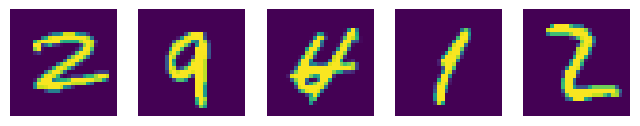

In [3]:
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()
xTrain, xTest = xTrain / 255.0, xTest / 255.0
yTrain, yTest = to_categorical(yTrain), to_categorical(yTest)
# expand images to 1 channel
xTrain = np.expand_dims(xTrain, axis=-1)
xTest = np.expand_dims(xTest, axis=-1)

_, boxes = plt.subplots(1, 5, figsize=(8, 8))

for box in boxes:
    index = random.randint(0, len(xTrain))
    box.imshow(xTrain[index])
    box.axis('off')

In [4]:
def FilterHeap(ch=8):
    return Sequential(
        [
            Conv2D(ch, 3, activation="relu"),
            MaxPooling2D(2),
            Conv2D(ch, 3, activation="relu"),
            MaxPooling2D(2),
            Conv2D(ch, 3, activation="relu"),
            Flatten(),
            Dense(10, activation="softmax"),
        ]
    )



In [5]:

class TransformerBlock(Layer):
    def __init__(self, embed, heads, expand):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=heads, key_dim=embed)
        self.ffn = Sequential(
            [layers.Dense(expand, activation="relu"), layers.Dense(embed)]
        )
        self.add = layers.Add()

    def call(self, inputs): 
        att_out = self.att(inputs, inputs)
        res_out = self.add([inputs, att_out])
        ffn_out = self.ffn(res_out)
        return self.add([res_out, ffn_out])


class TransformerModel(Model):
    def __init__(self, layers=16, embed=128, heads=4, expand=256, classes=10, activations=10906):
        super().__init__()

        self.embedder = Sequential(
            [
                Dense(expand, activation="relu"),
                Dense(embed, activation="relu"),
            ]
        )

        self.class_token = self.add_weight(shape=(1, 1, embed), initializer="zeros", trainable=True)
        self.policy_token = self.add_weight(shape=(1, 1, embed), initializer="zeros", trainable=True)

        self.blocks = []
        for _ in range(layers):
            self.blocks.append(TransformerBlock(embed, heads, expand))


        self.classification_head = Sequential(
            [
                Dense(expand, activation="relu"),
                Dense(expand, activation="relu"),
                Dense(classes, activation="softmax"),
            ]
        )
        self.policy_head = Sequential(
            [
                Dense(expand, activation="relu"),
                Dense(expand, activation="relu"),
                Dense(activations, activation="softmax"),
            ]
        )

    def call(self, inputs):
        x = self.embedder(inputs)
        # prepend the class and policy tokens to the embedded sequence, duplicating for the batch
        x = tf.concat([tf.tile(self.class_token, [tf.shape(x)[0], 1, 1]), x], axis=1)
        x = tf.concat([tf.tile(self.policy_token, [tf.shape(x)[0], 1, 1]), x], axis=1)
        for block in self.blocks:
            x = block(x)
        # pass the class token to the classification head, and the policy token to the policy head
        return self.classification_head(x[:, 0]), self.policy_head(x[:, 1])




In [6]:
vision = FilterHeap(8)

vision.compile(optimizer='adam',
                loss='categorical_crossentropy',
              metrics=['accuracy'])

vision.fit(xTrain, yTrain, epochs=4, batch_size=4000, validation_data=(xTest, yTest))



Metal device set to: Apple M2 Max

systemMemory: 96.00 GB
maxCacheSize: 36.00 GB

Epoch 1/4


2023-04-26 11:25:20.904843: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-26 11:25:20.905314: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-04-26 11:25:21.107565: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1/15 [=>............................] - ETA: 6s - loss: 2.3131 - accuracy: 0.0815

2023-04-26 11:25:21.355671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 34ms/step - loss: 2.2699 - accuracy: 0.1889 - val_loss: 2.2186 - val_accuracy: 0.2848
Epoch 2/4
 4/15 [=======>......................] - ETA: 0s - loss: 2.2113 - accuracy: 0.2950

2023-04-26 11:25:21.928415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 0s 22ms/step - loss: 2.1555 - accuracy: 0.3637 - val_loss: 2.0460 - val_accuracy: 0.4645
Epoch 3/4
15/15 [==============================] - 0s 21ms/step - loss: 1.9033 - accuracy: 0.5290 - val_loss: 1.6703 - val_accuracy: 0.5967
Epoch 4/4
15/15 [==============================] - 0s 23ms/step - loss: 1.4412 - accuracy: 0.6681 - val_loss: 1.1374 - val_accuracy: 0.7277


In [7]:
def GetActivations(model, inputs):
    activations = []
    for layer in model.layers:
        inputs = layer(inputs)
        activations.append(tf.reshape(inputs, [inputs.shape[0], -1]))
    activations = tf.concat(activations, axis=1)
    return activations


def SampleSequence(activations, indices):
    sequence = tf.concat([
        tf.one_hot(indices, activations.shape[1]),
        tf.expand_dims(tf.gather(activations, indices, axis=1, batch_dims=1), axis=2)
    ], axis=2)
    return sequence


def generator(images, labels, batch_size=500):
    num_samples = len(images)
    for i in range(0, num_samples, batch_size):
        x_batch = images[i:i + batch_size]
        y_batch = labels[i:i + batch_size]
        activations_batch = GetActivations(vision, x_batch)
        act_sequence = SampleSequence(activations_batch, tf.random.uniform([batch_size, s_len], maxval=a_num, dtype=tf.int32))
        yield act_sequence, y_batch

a_num = GetActivations(vision, xTrain[:1]).shape[1]
s_len = 16

train_dataset = tf.data.Dataset.from_generator(
    generator,
    args=(xTrain, yTrain),
    output_signature=(
        tf.TensorSpec(shape=(None, s_len, a_num+1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 10), dtype=tf.uint8)
    )
)

test_dataset = tf.data.Dataset.from_generator(
    generator,
    args=(xTest, yTest),
    output_signature=(
        tf.TensorSpec(shape=(None, s_len, a_num+1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 10), dtype=tf.uint8)
    )
)

for x, y in train_dataset.take(2):
    print(x.shape)
    print(y.shape)

print(xTrain.shape)


(500, 16, 8083)
(500, 10)
(500, 16, 8083)
(500, 10)
(60000, 28, 28, 1)


```python
seq_len = 64
trainN = 8000
testN = 500

sequence_train = SampleSequence(
    GetActivations(vision, xTrain[:trainN]),
    tf.random.uniform([trainN, seq_len], maxval=a_num, dtype=tf.int32)
)

sequence_test = SampleSequence(
    GetActivations(vision, xTest[:testN]),
    tf.random.uniform([testN, seq_len], maxval=a_num, dtype=tf.int32)
)
```


In [8]:

learner = TransformerModel(layers=8, embed=128, heads=4, expand=256, classes=10, activations=a_num)

learner.compile(optimizer='adam',
            loss=[keras.losses.CategoricalCrossentropy(), None],
              metrics=['accuracy'])


In [9]:

learner.fit(train_dataset, epochs=10, validation_data=(test_dataset))

Epoch 1/10


2023-04-26 11:25:47.113788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


    120/Unknown - 198s 2s/step - loss: 2.3067 - output_1_loss: 2.3067 - output_1_accuracy: 0.1078 - output_2_accuracy: 0.0000e+00

2023-04-26 11:29:03.641308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 207s 2s/step - loss: 2.3067 - output_1_loss: 2.3067 - output_1_accuracy: 0.1078 - output_2_accuracy: 0.0000e+00 - val_loss: 2.3012 - val_output_1_loss: 2.3012 - val_output_1_accuracy: 0.1135 - val_output_2_accuracy: 0.0000e+00
Epoch 2/10
120/120 [==============================] - 202s 2s/step - loss: 2.2835 - output_1_loss: 2.2835 - output_1_accuracy: 0.1359 - output_2_accuracy: 0.0000e+00 - val_loss: 2.2497 - val_output_1_loss: 2.2497 - val_output_1_accuracy: 0.1593 - val_output_2_accuracy: 0.0000e+00
Epoch 3/10
120/120 [==============================] - 205s 2s/step - loss: 2.2037 - output_1_loss: 2.2037 - output_1_accuracy: 0.1832 - output_2_accuracy: 0.0000e+00 - val_loss: 2.1619 - val_output_1_loss: 2.1619 - val_output_1_accuracy: 0.1997 - val_output_2_accuracy: 0.0000e+00
Epoch 4/10
120/120 [==============================] - 204s 2s/step - loss: 2.1564 - output_1_loss: 2.1564 - output_1_accuracy: 0.2019 - output_2_accuracy: 0.0000e+00 - 

In [10]:
a_num = GetActivations(vision, xTrain[:1]).shape[1]
s_len = 17

train_dataset = tf.data.Dataset.from_generator(
    generator,
    args=(xTrain, yTrain),
    output_signature=(
        tf.TensorSpec(shape=(None, s_len, a_num+1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 10), dtype=tf.uint8)
    )
)

test_dataset = tf.data.Dataset.from_generator(
    generator,
    args=(xTest, yTest),
    output_signature=(
        tf.TensorSpec(shape=(None, s_len, a_num+1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 10), dtype=tf.uint8)
    )
)

learner.fit(train_dataset, epochs=1, validation_data=(test_dataset))

2023-04-26 11:59:58.384526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


    120/Unknown - 208s 2s/step - loss: 1.7770 - output_1_loss: 1.7770 - output_1_accuracy: 0.3573 - output_2_accuracy: 0.0000e+00

2023-04-26 12:03:25.692137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 217s 2s/step - loss: 1.7770 - output_1_loss: 1.7770 - output_1_accuracy: 0.3573 - output_2_accuracy: 0.0000e+00 - val_loss: 1.7507 - val_output_1_loss: 1.7507 - val_output_1_accuracy: 0.3703 - val_output_2_accuracy: 0.0000e+00
